In [35]:
import pandas as pd
#import libraries
import glob
import pandas as pd
import numpy as np
import scipy.stats.distributions as sts
from scipy.stats import norm
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import minimize
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller


In [6]:
# rents
df = pd.read_csv('US_rental_city.csv')

df_t = df.T
df_ts = df_t.iloc[8:,:]
df_ts.columns = df_t.loc['RegionName']+' ('+ df['State'] +')'

df_ts=df_ts.astype(float)   
df_ts=df_ts.loc[:,df_ts.isna().sum()<=10] 
df_ts_filtred = df_ts.loc[:, df_ts.isna().sum() <= 15]
df_ts_filtred=df_ts_filtred.interpolate(method='linear')


# price

df_value = pd.read_csv('US_value_city.csv')

df_value_t = df_value.T
df_value_ts = df_value_t.iloc[8:,:]
df_value_ts.columns = df_value_t.loc['RegionName']+' ('+ df_value['State'] +')'

df_value_ts=df_value_ts.astype(float)   
df_value_ts=df_value_ts.loc[:,df_value_ts.isna().sum()<=10] 
df_value_ts_filtred = df_value_ts.loc[:, df_value_ts.isna().sum() <= 15]
df_value_ts_filtred=df_value_ts_filtred.interpolate(method='linear')

# US average
us_avg1 =  pd.read_csv('US_avg.csv')
us_avg = pd.Series(us_avg1.iloc[:,1])
us_avg.index = us_avg1.iloc[:,0]
us_avg_value1 =  pd.read_csv('US_value_avg.csv')
us_avg_value = pd.Series(us_avg_value1.iloc[:,1])
us_avg_value.index = us_avg_value1.iloc[:,0]

In [51]:



class risk_analysis:

    def __init__(self,df,asset_names_or_number,us_avg,risk_free_rate) -> None:
        
        
        if type(asset_names_or_number) == list:
            self.data = df.loc[asset_names_or_number]

        elif type(asset_names_or_number) == int:
            self.data = df.iloc[:,:asset_names_or_number]
        else:
            print('wrong input type')
        self.us_avg_data = us_avg

        self.returns = self.data.pct_change().dropna()
        self.correlation = self.returns.corr()
        # self.mean_returns = self.returns.mean()
        self.distance = 1 - self.correlation
        self.us_avg_returns = self.us_avg_data.pct_change().dropna()
        self.cov_matrix = self.returns.cov()
        self.alpha_beta= self.get_alpha_and_beta()
        self.risk_free_rate = risk_free_rate
        self.expected_returns = self.get_expected_returns_CAPM()

    
    def plot_correlation_matrix(self, figure_size=(15, 15)):
        
        plt.figure(figsize=figure_size)
        sns.heatmap(self.correlation, annot=True, cmap='coolwarm',
                    vmin=-1, vmax=1, center=0, fmt='.2f')
        plt.title('Correlation (historic) Matrix of rent Returns')
        plt.tight_layout()
        plt.show()


    def cluster_returns(self,n_clusters):

        kmeans = KMeans(n_clusters=5, random_state=0, n_init=10)

        clusters = kmeans.fit_predict(self.distance)
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(self.correlation)

        df_plot = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
        df_plot['City'] = self.correlation.columns
        df_plot['Cluster'] = clusters  

        plt.figure(figsize=(12, 8))
        sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_plot, palette='tab10', s=100)

        # Add labels
        for i, city in enumerate(df_plot['City']):
            plt.text(df_plot.iloc[i, 0]+0.02, df_plot.iloc[i, 1], city, fontsize=9)

        plt.title("PCA of Housing Market Correlations", fontsize=15)
        plt.xlabel(f"PC1 (Explains {pca.explained_variance_ratio_[0]:.1%} of variance)")
        plt.ylabel(f"PC2 (Explains {pca.explained_variance_ratio_[1]:.1%} of variance)")
        plt.axvline(0, color='grey', linestyle='--', alpha=0.5)
        plt.axhline(0, color='grey', linestyle='--', alpha=0.5)
        sns.despine()
        plt.show()

    def plot_season_variance(self):
       
        features = []

        for city in self.data.columns:

            decomp = seasonal_decompose(self.data[city].dropna(), model='additive', period=12)
            
            trend = decomp.trend.dropna()
            seasonal = decomp.seasonal.dropna()
            mean_price = self.data[city].mean()

            trend_strength = trend.std() / mean_price
            season_strength = seasonal.std() / mean_price
            
            features.append({
                'City': city,
                'Trend_Strength': trend_strength,
                'Seasonal_Strength': season_strength
            })

        df_features = pd.DataFrame(features).set_index('City')

        kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
        df_features['Cluster'] = kmeans.fit_predict(df_features[['Trend_Strength', 'Seasonal_Strength']])

        plt.figure(figsize=(10, 8))
        sns.scatterplot(
            data=df_features, 
            x='Trend_Strength', 
            y='Seasonal_Strength', 
            hue='Cluster', 
            palette='viridis', 
            s=150,
            edgecolor='black'
        )

        for i in range(df_features.shape[0]):
            if (df_features.iloc[i].Trend_Strength > df_features.Trend_Strength.quantile(0.7) or 
                df_features.iloc[i].Seasonal_Strength > df_features.Seasonal_Strength.quantile(0.7)):
                plt.text(
                    df_features.iloc[i].Trend_Strength, 
                    df_features.iloc[i].Seasonal_Strength, 
                    df_features.index[i], 
                    fontsize=9
                )

        plt.title('Clustering Cities: Seasonality vs. Trend (Normalized)', fontsize=16)
        plt.xlabel('Trend Magnitude (as % of Price)')
        plt.ylabel('Seasonal Magnitude (as % of Price)')
        plt.grid(True, alpha=0.3)
        plt.show()

        
    
    def plot_time_series_decompose(self,city_name, model='additive', period=12, bar_scaling_factor=10):
        """
        Plot the time series decomposition with clean yearly x-axis labels.
        """
        data = self.data[city_name]
        if not isinstance(data.index, pd.DatetimeIndex):
            data.index = pd.to_datetime(data.index)

        result = seasonal_decompose(data, model=model, period=period)
        fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

        components = ['Observed', 'Trend', 'Seasonal', 'Residual']
        plot_data = [result.observed, result.trend, result.seasonal, result.resid]

        global_range = np.nanmax(result.observed) - np.nanmin(result.observed)
        bar_height = global_range / bar_scaling_factor
        


        year_locator = mdates.YearLocator() 
        year_formatter = mdates.DateFormatter('%Y') 

        for ax, comp, series in zip(axs, components, plot_data):
            ax.plot(series.index, series.values, marker='o', markersize=1, linewidth=1)
            ax.set_title(comp, fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
            


            ax.xaxis.set_major_locator(year_locator)
            ax.xaxis.set_major_formatter(year_formatter)

            if len(series.dropna()) > 0: # Check to avoid errors on empty residuals
                x_loc = series.index[-1]
     
                y_min, y_max = ax.get_ylim()
                y_loc = y_min + 0.05 * (y_max - y_min)
                
                ax.vlines(x=x_loc, ymin=y_loc, ymax=y_loc + bar_height, color='red', linewidth=2)
                ax.text(x_loc, y_loc + bar_height / 2, f"{bar_height:.2e}", color='red',
                        va='center', ha='left', fontsize=9)


        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Stationarity Check
        print("--- Stationarity Test (ADF) ---")
        result_adf = adfuller(data.dropna()) # Drop NA for ADF or it will crash
        print(f"ADF Statistic: {result_adf[0]:.4f}")
        print(f"p-value: {result_adf[1]:.4f}")
        if result_adf[1] < 0.05:
            print("Result: Likely Stationary")
        else:
            print("Result: Likely Non-Stationary")

  
    def get_alpha_and_beta(self):
        """
        return: dataframe with alpha and beta for all assets
        """
        results = {'Asset': [], 'Alpha': [], 'Beta': []}
        
        #  Rename this ONCE outside the loop to ensure the column name exists
        market_returns = self.us_avg_returns.rename("market")

        for asset in self.returns.columns:
            y = self.returns[asset]
            
            # Concat the specific asset with the renamed market series
            # axis=1 lines them up by date (Index)
            valid_data = pd.concat([y, market_returns], axis=1).dropna()

            if len(valid_data) < 2:
                results['Asset'].append(asset)
                results['Alpha'].append(np.nan)
                results['Beta'].append(np.nan)
                continue

            X_valid = sm.add_constant(valid_data['market'])
            y_valid = valid_data[asset]

            model = sm.OLS(y_valid, X_valid).fit()

            results['Asset'].append(asset)
            results['Alpha'].append(model.params['const'])   # Alpha
            results['Beta'].append(model.params['market'])   # Beta

        results_CAPM = pd.DataFrame(results)
        return results_CAPM
    
    def plot_alpha_beta(self):
        """ plots alpha and beta values for all assets.
        """
        plt.figure(figsize=(10, 6))
        for x in self.alpha_beta.index:
            asset_alpha = self.alpha_beta.loc[x, 'Alpha']
            asset_beta = self.alpha_beta.loc[x, 'Beta']
            plt.scatter([asset_alpha], [asset_beta],
                        label=self.alpha_beta.loc[x, 'Asset'])
            plt.text(asset_alpha, asset_beta,
                    self.alpha_beta.loc[x, 'Asset'], fontsize=6, ha='left', va='bottom')
        plt.xlabel('alpha')
        plt.ylabel('beta')
        plt.title('alpha beta scatter plot')
        plt.grid(True)
        plt.show()

    def get_expected_returns_CAPM(self):

            
        expected_market_return = self.us_avg_returns.mean()

        expected_returns = pd.Series({
            asset: self.risk_free_rate + self.alpha_beta.loc[asset, 'Beta'] * (
                expected_market_return - self.risk_free_rate ) + self.alpha_beta.loc[asset, 'Alpha']
            for asset in self.alpha_beta.index
        })
        return expected_returns
        
    def plot_efficient_frontier(self, n_points=100):
        """
        Plots a smooth Efficient Frontier and fixes the labeling issue.
        """
        
        # 1. Ensure Expected Returns has the correct City Names
        if pd.api.types.is_integer_dtype(self.expected_returns.index):
            self.expected_returns.index = self.data.columns

        # --- A. Optimization Helpers ---
        def get_portfolio_variance(weights):
            return np.dot(weights.T, np.dot(self.cov_matrix, weights))

        def get_portfolio_return(weights):
            return np.sum(self.expected_returns * weights)

        def minimize_volatility(weights):
            return np.sqrt(get_portfolio_variance(weights))

        # --- B. Define the Sweep Range ---
        n_assets = len(self.expected_returns)
        args = (self.cov_matrix,)
        bounds = tuple((0, 1) for _ in range(n_assets))
        initial_guess = np.array([1 / n_assets] * n_assets)


        # The optimizer cannot find a portfolio with returns higher than your best asset.
        min_ret = self.expected_returns.min()
        max_ret = self.expected_returns.max()
        
        # We add a tiny buffer (1e-6) so we don't hit the absolute edge where solvers fail
        target_returns = np.linspace(min_ret, max_ret - 1e-6, n_points)

        efficient_volatilities = []
        efficient_returns = []

        for target in target_returns:
            constraints = (
                {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                {'type': 'eq', 'fun': lambda w: get_portfolio_return(w) - target}
            )
            
            # Increased maxiter to ensure convergence
            result = minimize(
                minimize_volatility, 
                initial_guess, 
                method='SLSQP', 
                bounds=bounds, 
                constraints=constraints,
                options={'maxiter': 1000} 
            )

            # Only add points if the solver actually succeeded
            if result.success:
                efficient_volatilities.append(result.fun)
                efficient_returns.append(target)

        # --- D. Plotting ---
        plt.figure(figsize=(12, 8))

        # Plot the Frontier
        if len(efficient_volatilities) > 0:
            plt.plot(efficient_volatilities, efficient_returns, 'k--', linewidth=2, label='Efficient Frontier')
        else:
            print("Warning: Optimizer failed to find the frontier. Check data for NaNs.")

        asset_vols = np.sqrt(np.diag(self.cov_matrix))
        sns.scatterplot(x=asset_vols, y=self.expected_returns, s=80, color='#1f77b4', zorder=2)

        for name, vol, ret in zip(self.expected_returns.index, asset_vols, self.expected_returns):
            plt.text(
                vol + (max(asset_vols) * 0.01), # Slight offset to the right
                ret, 
                str(name), # Force string conversion
                fontsize=9, 
                ha='left', 
                va='center'
            )

        market_vol = self.us_avg_returns.std()
        market_ret = self.us_avg_returns.mean()
        if isinstance(market_vol, pd.Series): 
            market_vol = market_vol.iloc[0]
            market_ret = market_ret.iloc[0]

        plt.scatter(market_vol, market_ret, c='red', s=150, marker='*', label='Market Avg', zorder=3)
        plt.text(market_vol, market_ret, '  Market', color='red', fontweight='bold', ha='left')

        plt.title('Efficient Frontier (Markowitz Portfolio Optimization)', fontsize=16)
        plt.xlabel('Risk (Volatility)', fontsize=12)
        plt.ylabel('Return (Expected)', fontsize=12)
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        sns.despine()
        plt.show()
        

    


In [52]:



class MarketArbitrage:
    def __init__(self, rent_obj, price_obj):
        """
        Args:
            rent_obj (risk_analysis): Instance containing RENT data
            price_obj (risk_analysis): Instance containing PRICE data
        """
        self.rent_obj = rent_obj
        self.price_obj = price_obj
        
        # Access the raw dataframes from your existing objects
        self.rents = rent_obj.data
        self.prices = price_obj.data
        self.rents_returns = rent_obj.returns
        self.prices_returns = price_obj.returns

        self.price_rent_corr = self.prices_returns.corrwith(self.rents_returns)


    def plot_correlation_rent_value(self):
        correlations = self.price_rent_corr.sort_values()

        plt.figure(figsize=(10, max(6, len(correlations) * 0.25)))

        sns.barplot(x=correlations.values, y=correlations.index)

        plt.title('Correlation: Home Prices vs. Rents', fontsize=16)
        plt.xlabel('Correlation Coefficient (Pearson)', fontsize=12)
        plt.axvline(0, color='black', linewidth=1)
        plt.grid(axis='x', linestyle='--', alpha=0.5)
        sns.despine()

        plt.show()
            
    def plot_cross_sectional_valuation(self, date_index=-1):
        """
        Method 1: Compares all cities at a single point in time.
        Identifies if a city is expensive relative to the National Rent/Price trend.
        """
        # 1. Get snapshot
        latest_prices = self.prices.iloc[date_index]
        latest_rents = self.rents.iloc[date_index]
        
        latest_prices = latest_prices[~latest_prices.index.duplicated(keep='first')]
        latest_rents = latest_rents[~latest_rents.index.duplicated(keep='first')]

        df = pd.DataFrame({'Price': latest_prices, 'Rent': latest_rents}).dropna()
    
        X = df[['Rent']]
        y = df['Price']
        
        model = LinearRegression()
        model.fit(X, y)
        
        # Mispricing (Z-Score)
        df['Predicted_Price'] = model.predict(X)
        df['Mispricing'] = df['Price'] - df['Predicted_Price']
        df['Z_Score'] = (df['Mispricing'] - df['Mispricing'].mean()) / df['Mispricing'].std()
        
        self.latest_valuation = df


        df_sorted = df.sort_values('Z_Score')
        plt.figure(figsize=(12, max(6, len(df_sorted) * 0.25)))
        colors = ['#d62728' if z > 1 else '#2ca02c' if z < -1 else 'lightgrey' for z in df_sorted['Z_Score']]

        sns.barplot(x=df_sorted['Z_Score'], y=df_sorted.index, palette=colors)
        
        plt.axvline(0, color='black', linestyle='--')
        plt.axvline(1, color='red', linestyle=':', label='Overvalued (>1σ)')
        plt.axvline(-1, color='green', linestyle=':', label='Undervalued (<-1σ)')
        
        plt.title('Cross-Sectional Valuation: Which Cities are Cheap vs. Rents?', fontsize=16)
        plt.xlabel('Z-Score (Standard Deviations from Fair Value)')
        plt.legend()
        sns.despine()
        plt.tight_layout()
        plt.show()

    def analyze_historical_fair_value(self, city_name, window=None):
        """
        Method 2: Analyzes one city over time.
        Checks if the current Price/Rent ratio is abnormal for that specific city.
        """
        # Extract Data
        if city_name not in self.prices.columns or city_name not in self.rents.columns:
            print(f"Error: {city_name} not found.")
            return

        ts_price = self.prices[city_name]
        ts_rent = self.rents[city_name]

        #  Align & Ratio
        df = pd.concat([ts_price, ts_rent], axis=1).dropna()
        df.columns = ['Price', 'Rent']
        df['Ratio'] = df['Price'] / df['Rent']


        if window:
            mean_ratio = df['Ratio'].rolling(window=window).mean()
            std_ratio = df['Ratio'].rolling(window=window).std()
            label_txt = f'{window}-Month Moving Avg'
        else:
            mean_ratio = df['Ratio'].mean()
            std_ratio = df['Ratio'].std()
            label_txt = 'Historical Mean'

        upper = mean_ratio + (2 * std_ratio)
        lower = mean_ratio - (2 * std_ratio)

        plt.figure(figsize=(12, 6))
        df.index = pd.to_datetime(df.index)

        plt.plot(df.index, df['Ratio'], label='Price/Rent Ratio', color='#1f77b4')
        
        if window:
            plt.plot(df.index, mean_ratio, color='black', linestyle='--', label=label_txt)
            plt.fill_between(df.index, lower, upper, color='gray', alpha=0.1)
        else:
            plt.axhline(mean_ratio, color='black', linestyle='--', label=label_txt)
            plt.axhspan(lower, upper, color='gray', alpha=0.1)

        ax = plt.gca()
        ax.xaxis.set_major_locator(mdates.YearLocator()) 
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
        plt.gcf().autofmt_xdate() 
        plt.title(f"{city_name}: Price-to-Rent Mean Reversion", fontsize=16)
        plt.legend()
        sns.despine()
        plt.show()

    def scan_for_opportunities(self, correlation_threshold=0.5):
        """
        MASTER STRATEGY: 
        Finds cities that are:
        1. Fundamentally sound (High Price-Rent Correlation)
        2. Currently Mispriced (High Z-Score in Cross-Sectional analysis)
        """
        # Run the valuation if it hasn't been run yet
        if not hasattr(self, 'latest_valuation'):
            print("Running valuation model first...")
            self.plot_cross_sectional_valuation() 

        # Merge Valuation Data with Correlation Data
        opportunities = self.latest_valuation.copy()
        opportunities['Correlation'] = self.price_rent_corr

        # Filter: Only look at cities where Price usually follows Rent
        valid_opps = opportunities[opportunities['Correlation'] > correlation_threshold].sort_values('Z_Score')

        print(f"--- Top Opportunities (Corr > {correlation_threshold}) ---")
        print(valid_opps[['Z_Score', 'Correlation', 'Price', 'Rent']].head())
        print("\n--- Top Risks (Overvalued) ---")
        print(valid_opps[['Z_Score', 'Correlation', 'Price', 'Rent']].tail())
        
        return valid_opps

In [53]:
obj = risk_analysis(df=df_ts_filtred,asset_names_or_number=35,us_avg=us_avg,risk_free_rate=0)
obj2= risk_analysis(df_value_ts_filtred,35,us_avg_value,0)
strategy = MarketArbitrage(rent_obj=obj, price_obj=obj2)


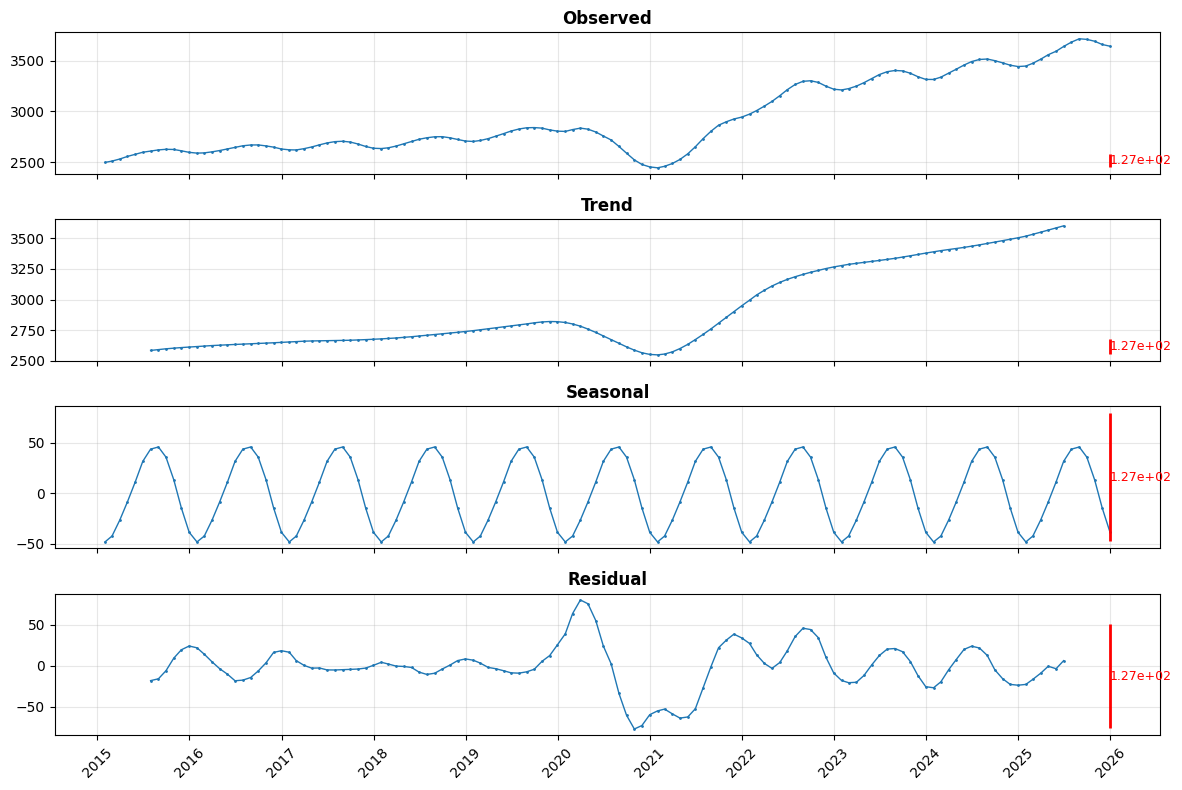

--- Stationarity Test (ADF) ---
ADF Statistic: 0.5933
p-value: 0.9874
Result: Likely Non-Stationary


In [54]:
obj.plot_time_series_decompose('New York (NY)','additive')

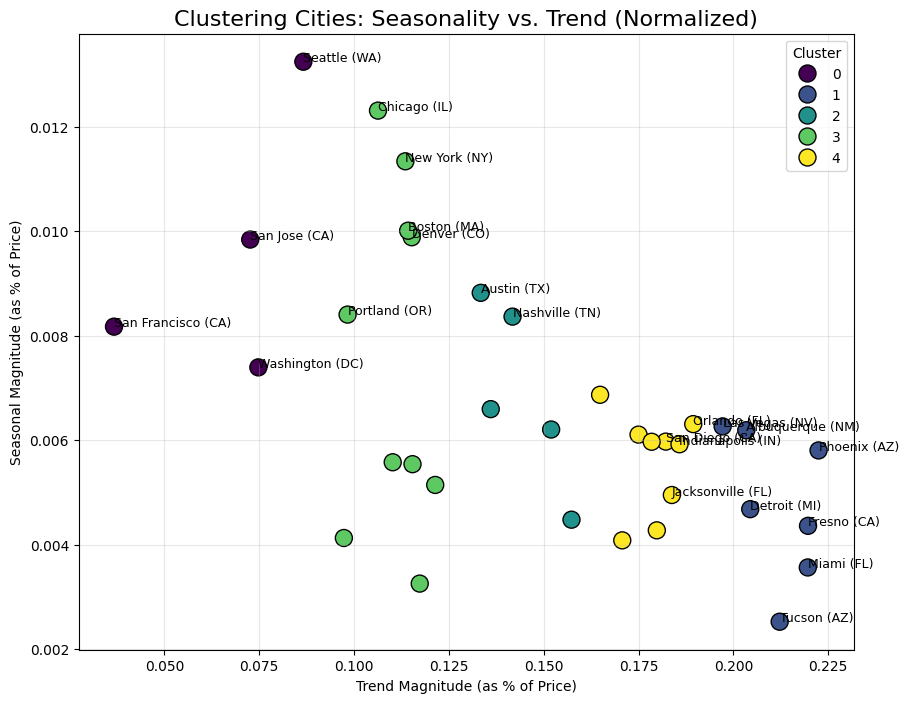

In [30]:
obj.plot_season_variance()

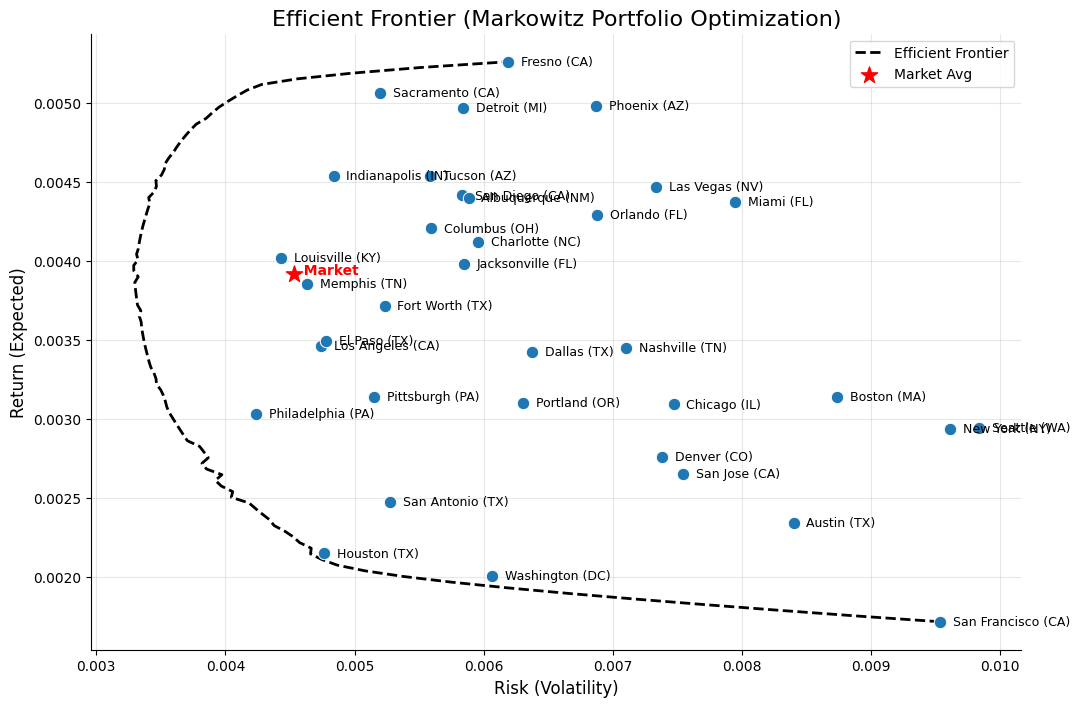

In [31]:
obj.plot_efficient_frontier()

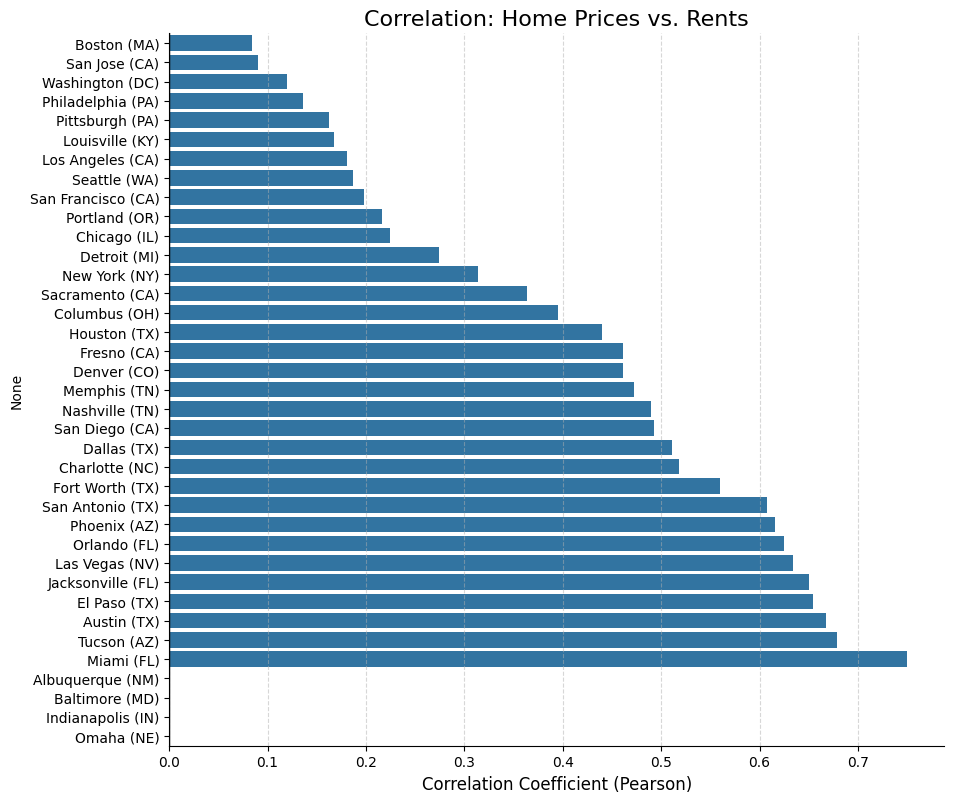

In [32]:
strategy.plot_correlation_rent_value()

C:\Users\steph\AppData\Local\Temp\ipykernel_98612\3003645292.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_sorted['Z_Score'], y=df_sorted.index, palette=colors)


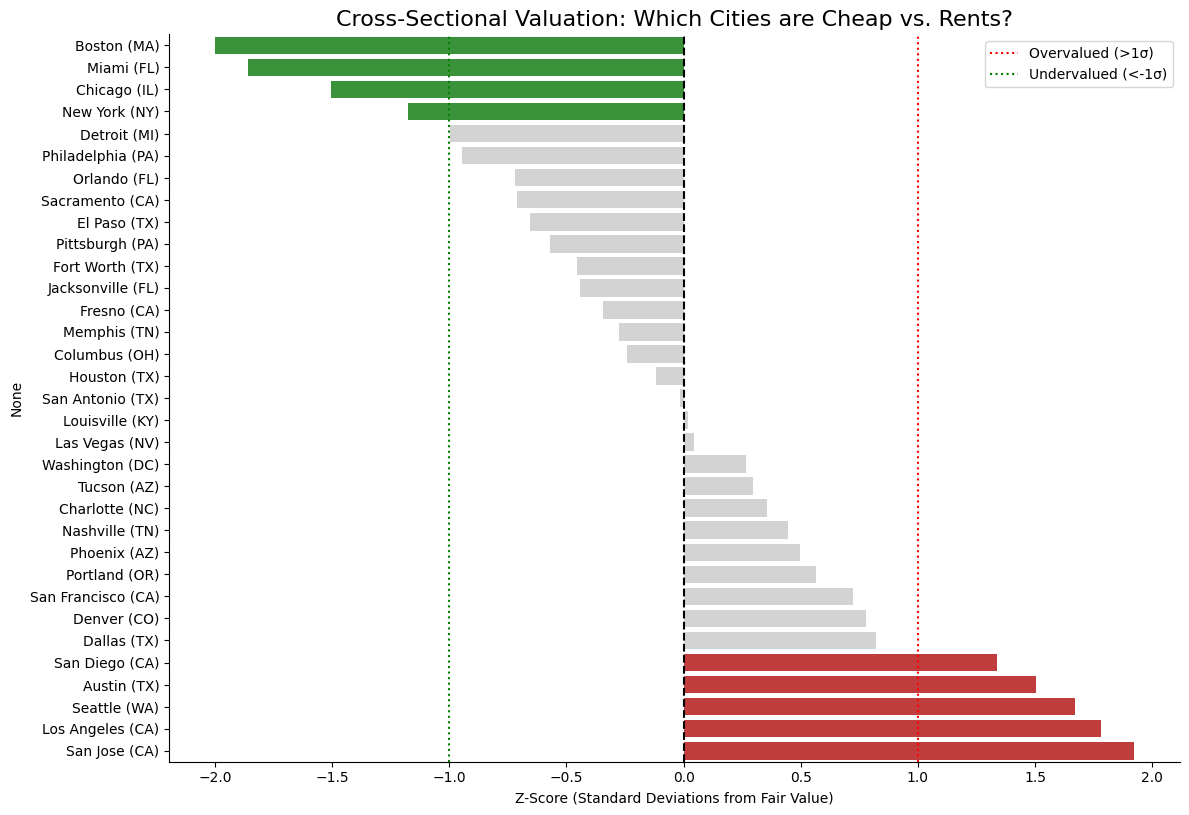

In [33]:
strategy.plot_cross_sectional_valuation()

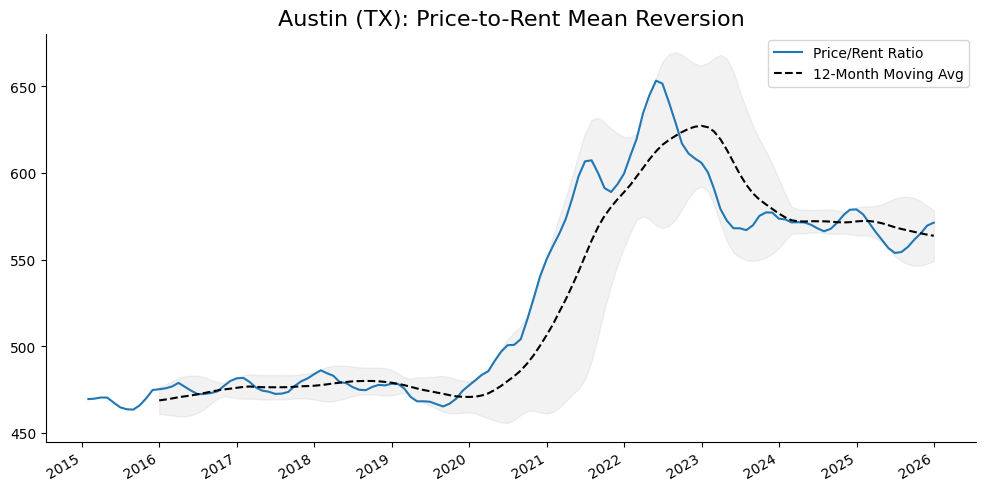

In [34]:
strategy.analyze_historical_fair_value('Austin (TX)',window=12)